In [1]:
import torch
from torch.utils.data import DataLoader,random_split
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets,transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time,os
from sklearn.metrics import confusion_matrix,classification_report, ConfusionMatrixDisplay

device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
torch.cuda.is_available()

False

In [3]:
print(device)

cpu


In [4]:
#load and transform data

data_dir=r"C:\Users\USER\Downloads\archive (23)\PlantVillage"

In [5]:
#define transformation for train and val set

train_transform=transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])


val_transform=transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

dataset=datasets.ImageFolder(root=data_dir,transform=train_transform)

In [6]:
dataset

Dataset ImageFolder
    Number of datapoints: 20638
    Root location: C:\Users\USER\Downloads\archive (23)\PlantVillage
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [7]:
len(dataset)

20638

In [8]:
#split into train and validation
train_size=int(0.8 * len(dataset))
train_size

16510

In [9]:
#val_ size
val_size=len(dataset) - train_size

In [10]:
train_dataset,val_dataset=random_split(dataset,[train_size,val_size])

In [11]:

val_dataset.dataset.transform=val_transform

In [12]:
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=32,shuffle=True)

In [13]:
class_name=dataset.classes
print(f"Classes: {class_name}")
print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")


Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Training samples: 16510, Validation samples: 4128


In [14]:
#CNN WITH SOME CONVULATIONAL LAYER

class DeepPotato(nn.Module):
    def __init__(self, num_classes):
        super(DeepPotato,self).__init__()

        self.features=nn.Sequential(
            nn.Conv2d(3,32,kernel_size=3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(32,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64,128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(128,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

        )

        self.classifier=nn.Sequential(nn.AdaptiveAvgPool2d((1,1)),nn.Flatten(),nn.Dropout(0.5),nn.Linear(256,num_classes))

    def forward(self, x):
            x=self.features(x)
            x=self.classifier(x)
            return x

model=DeepPotato(num_classes=len(class_name)).to(device)
print(model)


DeepPotato(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [15]:
#define loss, optimizer and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


In [16]:

num_epochs = 5
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = 100 * correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
    scheduler.step()


    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    val_loss /= total
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    scheduler.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")


Epoch [1/5] - Loss: 1.0685, Acc: 66.61%
Epoch [1/5] | Train Loss: 1.0685, Acc: 66.6081 | Val Loss: 0.7531, Acc: 0.7493
Epoch [2/5] - Loss: 0.6060, Acc: 80.79%
Epoch [2/5] | Train Loss: 0.6060, Acc: 80.7874 | Val Loss: 0.3722, Acc: 0.8888
Epoch [3/5] - Loss: 0.4422, Acc: 85.97%
Epoch [3/5] | Train Loss: 0.4422, Acc: 85.9661 | Val Loss: 0.4157, Acc: 0.8583
Epoch [4/5] - Loss: 0.2977, Acc: 90.71%
Epoch [4/5] | Train Loss: 0.2977, Acc: 90.7147 | Val Loss: 0.1844, Acc: 0.9445
Epoch [5/5] - Loss: 0.2587, Acc: 91.64%
Epoch [5/5] | Train Loss: 0.2587, Acc: 91.6414 | Val Loss: 0.1959, Acc: 0.9419


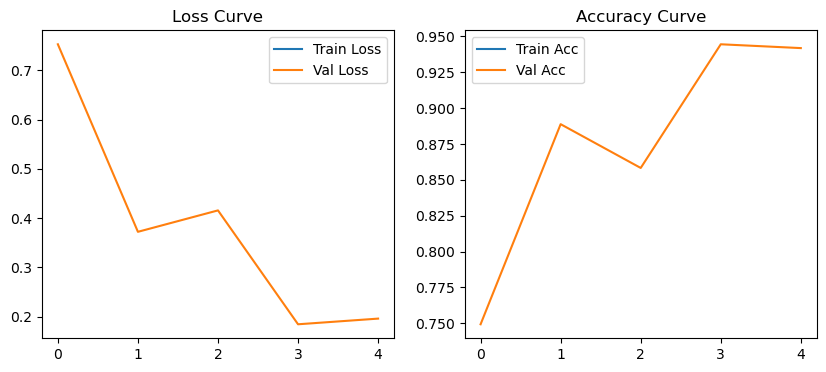

<Figure size 640x480 with 0 Axes>

In [26]:

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend(); plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.legend(); plt.title("Accuracy Curve")
plt.show()
plt.savefig("loss_curve_and_val_accuracy.png")

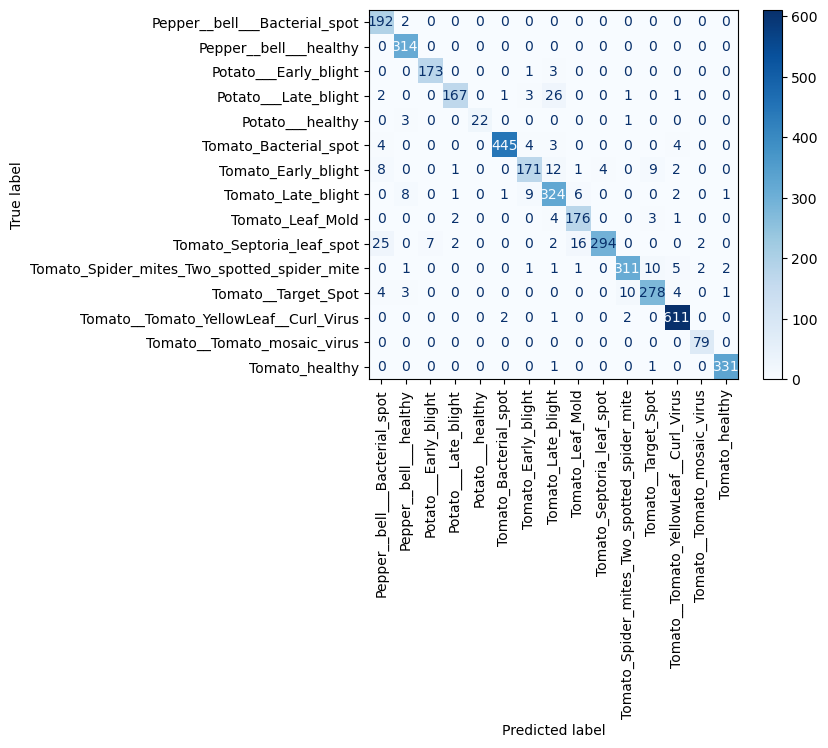

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.82      0.99      0.90       194
                     Pepper__bell___healthy       0.95      1.00      0.97       314
                      Potato___Early_blight       0.96      0.98      0.97       177
                       Potato___Late_blight       0.97      0.83      0.89       201
                           Potato___healthy       1.00      0.85      0.92        26
                      Tomato_Bacterial_spot       0.99      0.97      0.98       460
                        Tomato_Early_blight       0.90      0.82      0.86       208
                         Tomato_Late_blight       0.86      0.92      0.89       352
                           Tomato_Leaf_Mold       0.88      0.95      0.91       186
                  Tomato_Septoria_leaf_spot       0.99      0.84      0.91       348
Tomato_Spider_mites_Two_spotted_spider_mite       0.96      0.93

<Figure size 640x480 with 0 Axes>

In [25]:

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_name)
disp.plot(xticks_rotation=90, cmap='Blues')
plt.show()
plt.savefig("potato_disease_confusion_matrix.png",dpi=300)
print(classification_report(all_labels, all_preds, target_names=class_name))



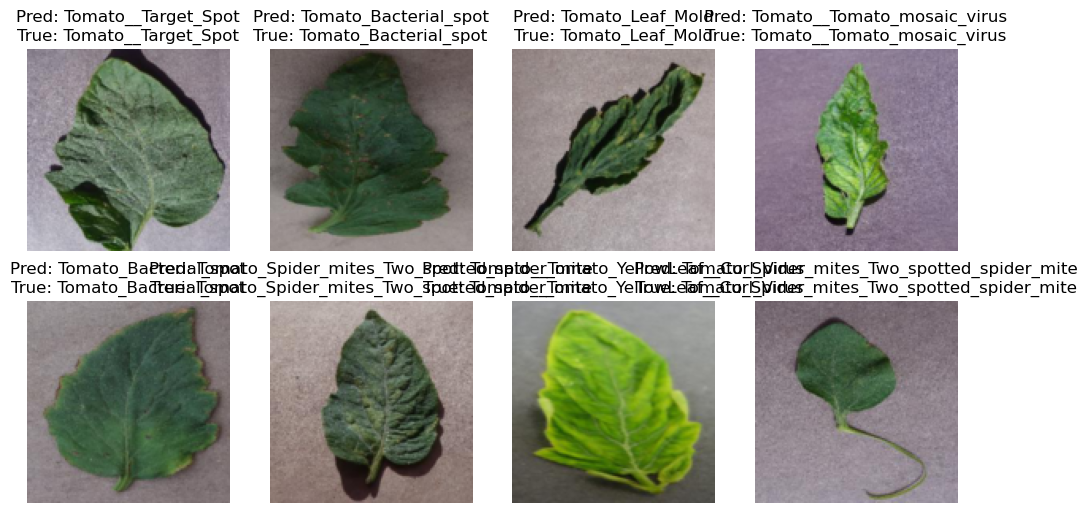

In [23]:

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy().transpose((1, 2, 0))
    plt.imshow(npimg)

dataiter = iter(val_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

outputs = model(images)
_, preds = torch.max(outputs, 1)

plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    imshow(images[i].cpu())
    plt.title(f"Pred: {class_name[preds[i]]}\nTrue: {class_name[labels[i]]}")
    plt.axis('off')
plt.show()


In [24]:

torch.save(model.state_dict(), "potato_disease_cnn.pth")
print("Model saved as potato_disease_cnn.pth")


Model saved as potato_disease_cnn.pth
